This code tests fetching BDC images on AWS environment

In [1]:
import pystac_client
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import rasterio
import math
import os
from tqdm import tqdm
from rasterio.crs import CRS
from rasterio.warp import transform
from rasterio.windows import from_bounds
from rasterio.mask import mask
import numpy as np
from geopy.distance import geodesic
from matplotlib import pyplot as plt
from rasterio.windows import Window, transform as window_transform

In [2]:
# using Brazil Data Cube as data source
service = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')  #('https://bdc-sentinel-2.s3.us-west-2.amazonaws.com/catalog.json')

In [3]:
# using Collection Sentinel-2
collection = service.get_collection('S2-16D-2')

In [4]:
# Define de ROI bbox
center_point = (-15.885858,-47.725772) # Taboquinha

# Define the distance to extend
ns_distance_km = 2.7
we_distance_km = 2.7

# Calculate the boundary box
bb_north = geodesic(kilometers=ns_distance_km/2).destination(center_point, 0).latitude
bb_south = geodesic(kilometers=ns_distance_km/2).destination(center_point, 180).latitude
bb_east = geodesic(kilometers=we_distance_km/2).destination(center_point, 90).longitude
bb_west = geodesic(kilometers=we_distance_km/2).destination(center_point, 270).longitude
bbox = (bb_west, bb_south, bb_east, bb_north)

print(f"Bounding box:\nSouth: {bb_south} \tWest: {bb_west}\nNorth: {bb_north} \tEast: {bb_east}")
print(f"bbox = {bbox}")

Bounding box:
South: -15.898057796775847 	West: -47.73837763779424
North: -15.873658189482754 	East: -47.71316636220576
bbox = (-47.73837763779424, -15.898057796775847, -47.71316636220576, -15.873658189482754)


In [5]:
# To minimize the clouds distorition, let's define a search time interval from july to august (in general, less cloudy season).
datetime = '2024-07-01/2024-08-31'

In [6]:
# search items
item_search = service.search(bbox=bbox,
                             datetime=datetime,
                             collections=['S2-16D-2'])
item_search

In [7]:
print(f'number of images in the collection: {item_search.matched()}')

number of images in the collection: 5


----

In [8]:
def read_multiple_items(items, band_name, bbox, masked=True, crs=None):
    source_crs = CRS.from_string('EPSG:4326')
    if crs:
        source_crs = CRS.from_string(crs)
    
    data_list = []
    transforms = []
    crs_list = []
    
    for item in items:
        uri = item.assets[band_name].href
        
        # Expects the bounding box has 4 values
        w, s, e, n = bbox
        
        with rasterio.open(uri) as dataset:
            # Transform the bounding box to the dataset's CRS
            xs, ys = transform(source_crs, dataset.crs, [w, e], [s, n])
            # Create a window from the transformed bounds
            window = from_bounds(xs[0], ys[0], xs[1], ys[1], dataset.transform)
            # Read the data within the window
            data = dataset.read(1, window=window, masked=masked)
            # Get the transform for the windowed data
            window_transform = dataset.window_transform(window)
            # Get the CRS of the dataset
            data_crs = dataset.crs
            
            data_list.append(data)
            transforms.append(window_transform)
            crs_list.append(data_crs)
    
    return data_list, transforms, crs_list

In [9]:
# Convert item_search.items() to a list to reuse
items_list = list(item_search.items())


In [10]:
# Consider four bands: red, green, blue and NIR.
# Observe that the read function consider a collection of images
red_data_list, red_transforms, red_crs_list = read_multiple_items(items_list, 'B04', bbox)
green_data_list, green_transforms, green_crs_list = read_multiple_items(items_list, 'B03', bbox)
blue_data_list, blue_transforms, blue_crs_list = read_multiple_items(items_list, 'B02', bbox)
nir_data_list, nir_transforms, nir_crs_list = read_multiple_items(items_list, 'B08', bbox)

In [11]:
# Compute median bands to mitigate the cloud distortion
def compute_median_band(band_data_list):
    data_stack = ma.stack(band_data_list, axis=0)
    median_band = ma.median(data_stack, axis=0)
    return median_band

In [12]:
median_red = compute_median_band(red_data_list)
median_green = compute_median_band(green_data_list)
median_blue = compute_median_band(blue_data_list)
median_nir = compute_median_band(nir_data_list)

In [13]:
# Prepare median bands for writing
# force float32 data type for later treatment with TensorFlow
nodata_value = -9999.0
median_red_filled = median_red.filled(nodata_value).astype('float32')
median_green_filled = median_green.filled(nodata_value).astype('float32')
median_blue_filled = median_blue.filled(nodata_value).astype('float32')
median_nir_filled = median_nir.filled(nodata_value).astype('float32')

In [14]:
# Extract the first 256 rows and columns for each band
median_red_subset = median_red_filled[0:256, 0:256]
median_green_subset = median_green_filled[0:256, 0:256]
median_blue_subset = median_blue_filled[0:256, 0:256]
median_nir_subset = median_nir_filled[0:256, 0:256]

In [15]:
# Create a Window object for the subset
window = Window(0, 0, 256, 256)

In [16]:
# Compute the new affine transform for the subset
reference_transform = red_transforms[0]
new_transform = window_transform(window, reference_transform)

In [17]:
# Stack the median subsets
stacked_median_array = np.stack([
    median_red_subset,
    median_green_subset,
    median_blue_subset,
    median_nir_subset
])

In [18]:
# Update the output height and width
output_height, output_width = median_red_subset.shape


In [19]:
output_filename = 'median_composite.tif'
reference_crs = red_crs_list[0]

In [20]:
# Write the output file
with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=output_height,
    width=output_width,
    count=4,
    dtype='float32',
    crs=reference_crs,
    transform=new_transform,
    nodata=nodata_value
) as dst:
    dst.write(stacked_median_array)
    dst.set_band_description(1, 'Red')
    dst.set_band_description(2, 'Green')
    dst.set_band_description(3, 'Blue')
    dst.set_band_description(4, 'NIR')

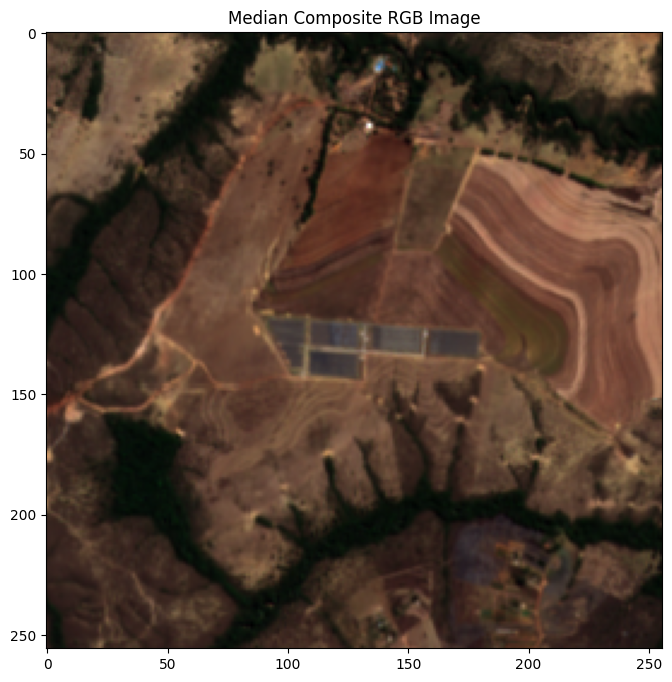

In [21]:
# normalize the array for visualization
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Stack normalized RGB bands
rgb_median = np.dstack((
    normalize(median_red_subset),
    normalize(median_green_subset),
    normalize(median_blue_subset)
))

# Plot the RGB image
plt.figure(figsize=(8, 8))
plt.imshow(rgb_median)
plt.title('Median Composite RGB Image')
plt.show()

-----

Now, I will adapt some functions to test the following process:

inputs: 
- center_coord: center coordinate for the bounding box rectangle
- ns_height: bounding box rectangle's height (Km)
- we_widht: bounding box rectangle's width (Km)
- transaction_ID: NNNNNN-YYYY-MM-DD (NNNNNN: 6 digit incremental value)

output:
- a sequence of images with the following format:
  input_NNNNNN-YYYY-MM-DD_RRR_CCC.tif where RRR is the row number, CCC is the column number.
  

In [22]:
def fetchBDC_images(service, transaction_ID, central_coord, sub_image_pixels, ns_height_km, we_width_km, date_interval, output_path):
    """
    Fetches images from Brazil Data Cube and mosaics them, ensuring output images are all sub_image_pixels x sub_image_pixels.
    """
    
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path, exist_ok=True)
        print(f"Created output directory: {output_path}")

    # Step 1 - Compute the initial bounding box
    original_bb_north = geodesic(kilometers=ns_height_km / 2).destination(central_coord, 0).latitude
    original_bb_south = geodesic(kilometers=ns_height_km / 2).destination(central_coord, 180).latitude
    original_bb_east = geodesic(kilometers=we_width_km / 2).destination(central_coord, 90).longitude
    original_bb_west = geodesic(kilometers=we_width_km / 2).destination(central_coord, 270).longitude
    bbox = (original_bb_west, original_bb_south, original_bb_east, original_bb_north)

    print(f"Initial Bounding Box:\nSouth: {original_bb_south} \tWest: {original_bb_west}\nNorth: {original_bb_north} \tEast: {original_bb_east}")
    print(80 * "-")

    # Step 2 - Find out the bbox size in pixels
    item_search = service.search(
        bbox=bbox,
        datetime=date_interval,
        collections=['S2-16D-2']
    )

    print(f'Number of images in the collection: {item_search.matched()}')

    # Convert item_search.items() to a list to reuse
    items_list = list(item_search.items())

    # Consider four bands: red, green, blue, and NIR
    red_data_list, red_transforms, red_crs_list = read_multiple_items(items_list, 'B04', bbox)
    median_red = compute_median_band(red_data_list)
    nodata_value = -9999.0
    median_red_filled = median_red.filled(nodata_value).astype('float32')
    
    # Step 3 - Determine the correct number of tiles
    full_height, full_width = median_red_filled.shape
    ratio_height = full_height / sub_image_pixels
    ratio_width = full_width / sub_image_pixels

    nb_rows = int(ratio_height) + 1
    nb_cols = int(ratio_width) + 1

    ori_ns_delta_deg = original_bb_north - original_bb_south
    ori_we_delta_deg = original_bb_east - original_bb_west

    ns_deg_by_row = ori_ns_delta_deg / ratio_height
    we_deg_by_col = ori_we_delta_deg / ratio_width

    # Step-3 Extend the bounding box area
    extended_bb_north = original_bb_north + ns_deg_by_row/2
    extended_bb_south = original_bb_south - ns_deg_by_row/2
    extended_bb_west = original_bb_west - we_deg_by_col/2
    extended_bb_east = original_bb_east + we_deg_by_col/2
    bbox = (extended_bb_west, extended_bb_south, extended_bb_east, extended_bb_north)

    print(80 * "-")
    print(f"Extended Bounding Box:\nSouth: {extended_bb_south} \tWest: {extended_bb_west}\nNorth: {extended_bb_north} \tEast: {extended_bb_east}")
    print(80 * "-")

    # Consider four bands: red, green, blue, and NIR
    red_data_list, red_transforms, red_crs_list = read_multiple_items(items_list, 'B04', bbox)
    green_data_list, green_transforms, green_crs_list = read_multiple_items(items_list, 'B03', bbox)
    blue_data_list, blue_transforms, blue_crs_list = read_multiple_items(items_list, 'B02', bbox)
    nir_data_list, nir_transforms, nir_crs_list = read_multiple_items(items_list, 'B08', bbox)

    # Compute median band values to absorb cloud distortions
    median_red = compute_median_band(red_data_list)
    median_green = compute_median_band(green_data_list)
    median_blue = compute_median_band(blue_data_list)
    median_nir = compute_median_band(nir_data_list)

    # Prepare median bands for writing
    nodata_value = -9999.0
    median_red_filled = median_red.filled(nodata_value).astype('float32')
    median_green_filled = median_green.filled(nodata_value).astype('float32')
    median_blue_filled = median_blue.filled(nodata_value).astype('float32')
    median_nir_filled = median_nir.filled(nodata_value).astype('float32')

    print(f"Splitting into {nb_cols} columns and {nb_rows} rows...")

    # Step 4 - Save sub-images with correct transform
    reference_transform = red_transforms[0]
    reference_crs = red_crs_list[0]

    with tqdm(total=nb_cols * nb_rows, desc="Processing tiles") as pbar:
        for j in range(nb_cols):
            for i in range(nb_rows):

                # Define slice bounds
                row_start = i * sub_image_pixels
                row_end = row_start + sub_image_pixels
                col_start = j * sub_image_pixels
                col_end = col_start + sub_image_pixels

                # Extract tile
                red_tile = median_red_filled[row_start:row_end, col_start:col_end]
                green_tile = median_green_filled[row_start:row_end, col_start:col_end]
                blue_tile = median_blue_filled[row_start:row_end, col_start:col_end]
                nir_tile = median_nir_filled[row_start:row_end, col_start:col_end]

                # Compute correct transform for this tile
                tile_window = Window(col_start, row_start, sub_image_pixels, sub_image_pixels)
                tile_transform = rasterio.windows.transform(tile_window, reference_transform)

                stacked_tile = np.stack([red_tile, green_tile, blue_tile, nir_tile])

                # Generate filename
                output_filename = os.path.join(output_path, f"{transaction_ID}_{i:03}_{j:03}.tif")

                # Write tile to file
                with rasterio.open(
                        output_filename,
                        'w',
                        driver='GTiff',
                        height=sub_image_pixels,
                        width=sub_image_pixels,
                        count=4,
                        dtype='float32',
                        crs=reference_crs,
                        transform=tile_transform,
                        nodata=nodata_value
                ) as dst:
                    dst.write(stacked_tile)
                    dst.set_band_description(1, 'Red')
                    dst.set_band_description(2, 'Green')
                    dst.set_band_description(3, 'Blue')
                    dst.set_band_description(4, 'NIR')

                # Log progress
                print(f"Tile {i}, {j} - Mean Red: {np.mean(red_tile)}")
                print(f"Image file: {output_filename} created. Shape: {stacked_tile.shape}")
                print(80 * "-")

                pbar.update(1)


In [23]:
transaction_ID = '200009' #'000001-2025-02-28'

fetchBDC_images(
    service, 
    transaction_ID = transaction_ID,
    central_coord =(-15.885858,-47.725772),
    sub_image_pixels = 256,
    ns_height_km = 10,
    we_width_km = 10,
    date_interval = '2024-07-01/2024-08-31',
    output_path = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection","acquisition", transaction_ID)
)

Created output directory: /home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009
Initial Bounding Box:
South: -15.931042363627931 	West: -47.772459546668316
North: -15.840673447875623 	East: -47.67908445333168
--------------------------------------------------------------------------------
Number of images in the collection: 5
--------------------------------------------------------------------------------
Extended Bounding Box:
South: -15.942714635289178 	West: -47.78430494998555
North: -15.829001176214376 	East: -47.66723905001445
--------------------------------------------------------------------------------
Splitting into 4 columns and 4 rows...


Processing tiles:  38%|███▊      | 6/16 [00:00<00:00, 55.18it/s]

Tile 0, 0 - Mean Red: 759.1296997070312
Image file: /home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_000_000.tif created. Shape: (4, 256, 256)
--------------------------------------------------------------------------------
Tile 1, 0 - Mean Red: 886.5307006835938
Image file: /home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_001_000.tif created. Shape: (4, 256, 256)
--------------------------------------------------------------------------------
Tile 2, 0 - Mean Red: 1160.74365234375
Image file: /home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_002_000.tif created. Shape: (4, 256, 256)
--------------------------------------------------------------------------------
Tile 3, 0 - Mean Red: 1357.4742431640625
Image file: /home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_003_000.tif created. Shape: (4, 256, 256)
-------------------------------------------------------------------------

Processing tiles: 100%|██████████| 16/16 [00:00<00:00, 46.14it/s]

Tile 2, 2 - Mean Red: 1138.65966796875
Image file: /home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_002_002.tif created. Shape: (4, 256, 256)
--------------------------------------------------------------------------------
Tile 3, 2 - Mean Red: 1025.2884521484375
Image file: /home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_003_002.tif created. Shape: (4, 256, 256)
--------------------------------------------------------------------------------
Tile 0, 3 - Mean Red: 816.3767700195312
Image file: /home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_000_003.tif created. Shape: (4, 256, 256)
--------------------------------------------------------------------------------
Tile 1, 3 - Mean Red: 915.6915283203125
Image file: /home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_001_003.tif created. Shape: (4, 256, 256)
-------------------------------------------------------------------------